In [1]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA
from asteria.simulation import Simulation
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


/usr/local/lib/python3.8/dist-packages/tqdm-4.65.0-py3.8.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dt = 0.1*u.ms # highest frequency in Tamborra 2014 model

model = {'name': 'Tamborra_2014',
         'param':{
             'progenitor_mass': 20*u.Msun,
             'direction': 1}
         }
sim = Simulation(model=model,
                 distance=10* u.kpc, 
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0.006*u.s, tmax=0.338*u.s, dt=dt,
                 hierarchy = 'normal',
                 mixing_scheme = 'NoTransformation',
                 geomscope = 'Gen2',
                 include_wls = False)
sim.run()

In [3]:
dt = 1 * u.ms
sasi_wind = [140, 300] * u.ms
ana_wind = [160, 275] * u.ms

In [4]:
distances = np.logspace(-1,2,num=50) * u.kpc
trials = 1000
R_i3, R_dc, R_md = [], [], []

for i, d in enumerate(distances):
    print('distance {:.2f}'.format(d))
    # scale the simulation to the right distance
    sim.scale_result(distance=d)
    
    # time and signal realization for each detector component
    t, s_i3 = sim.detector_hits(dt=dt, subdetector='i3', size=trials)
    t, s_dc = sim.detector_hits(dt=dt, subdetector='dc', size=trials)
    t, s_md = sim.detector_hits(dt=dt, subdetector='md', size=trials)
    t = t.to(u.ms)
    
    t_mask = np.logical_and(t>=ana_wind[0], t<=ana_wind[1])
    
    # dead time corrected, distance corrected signal
    s_i3 *= 1/sim.eps_i3 * 1/dt.to_value(u.s)
    s_dc *= 1/sim.eps_dc * 1/dt.to_value(u.s)
    s_md *= 1/sim.eps_md * 1/dt.to_value(u.s)

    # random background realization
    b_i3 = sim.detector.i3_bg(dt=dt, size=s_i3.shape[1]*trials)
    b_dc = sim.detector.dc_bg(dt=dt, size=s_dc.shape[1]*trials)
    b_md = sim.detector.md_bg(dt=dt, size=s_md.shape[1]*trials)
    
    # reshape background
    b_i3 = b_i3.reshape(trials,s_i3.shape[1])
    b_dc = b_dc.reshape(trials,s_dc.shape[1])
    b_md = b_md.reshape(trials,s_md.shape[1])
    
    # combined signal/background of subdetector components (i3,dc,md)
    r_i3 = s_i3 #+ b_i3
    r_dc = s_dc #+ b_dc
    r_md = s_md #+ b_md
    
    # take median of combined, dead time corrected detector rate for each trial
    rr_i3 = np.median(r_i3[:,t_mask])/sim.detector.n_i3_doms
    rr_dc = np.median(r_dc[:,t_mask])/sim.detector.n_dc_doms
    rr_md = np.median(r_md[:,t_mask])/sim.detector.n_md

    # take avg of all median values
    R_i3.append(rr_i3.mean())
    R_dc.append(rr_dc.mean())
    R_md.append(rr_md.mean())

R_i3 = np.array(R_i3)
R_dc = np.array(R_dc)
R_md = np.array(R_md)

distance 0.10 kpc
distance 0.12 kpc
distance 0.13 kpc
distance 0.15 kpc
distance 0.18 kpc
distance 0.20 kpc
distance 0.23 kpc
distance 0.27 kpc
distance 0.31 kpc
distance 0.36 kpc
distance 0.41 kpc
distance 0.47 kpc
distance 0.54 kpc
distance 0.63 kpc
distance 0.72 kpc
distance 0.83 kpc
distance 0.95 kpc
distance 1.10 kpc
distance 1.26 kpc
distance 1.46 kpc
distance 1.68 kpc
distance 1.93 kpc
distance 2.22 kpc
distance 2.56 kpc
distance 2.95 kpc
distance 3.39 kpc
distance 3.91 kpc
distance 4.50 kpc
distance 5.18 kpc
distance 5.96 kpc
distance 6.87 kpc
distance 7.91 kpc
distance 9.10 kpc
distance 10.48 kpc
distance 12.07 kpc
distance 13.89 kpc
distance 16.00 kpc
distance 18.42 kpc
distance 21.21 kpc
distance 24.42 kpc
distance 28.12 kpc
distance 32.37 kpc
distance 37.28 kpc
distance 42.92 kpc
distance 49.42 kpc
distance 56.90 kpc
distance 65.51 kpc
distance 75.43 kpc
distance 86.85 kpc
distance 100.00 kpc


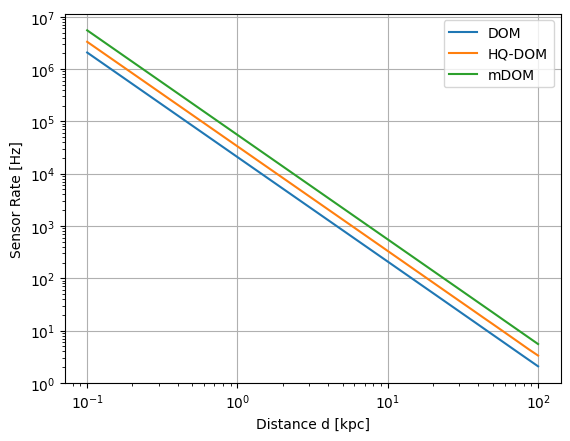

In [5]:
fig, ax = plt.subplots(1,1)

ax.plot(distances, R_i3, label = 'DOM')
ax.plot(distances, R_dc, label = 'HQ-DOM')
ax.plot(distances, R_md, label = 'mDOM')
ax.set_xlabel('Distance d [kpc]')
ax.set_ylabel('Sensor Rate [Hz]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
ax.legend()

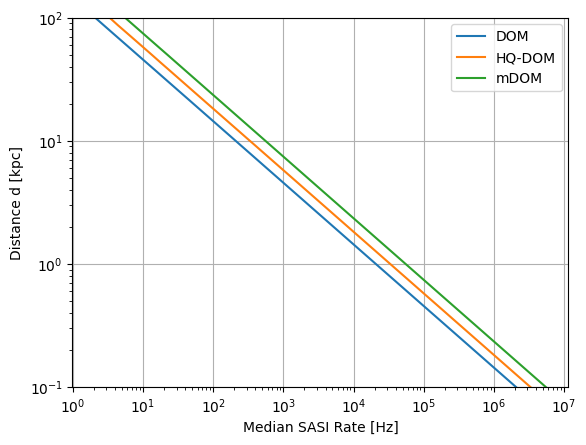

In [6]:
fig, ax = plt.subplots(1,1)

ax.plot(R_i3, distances, label = 'DOM')
ax.plot(R_dc, distances, label = 'HQ-DOM')
ax.plot(R_md, distances, label = 'mDOM')
ax.set_xlabel('Median SASI Rate [Hz]')
ax.set_ylabel('Distance d [kpc]')
ax.set_ylim(1E-1,1E2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
ax.legend()

In [ ]:
f = np.array([1,10,100,1000,10000,1E5, 1E20])
def dte(f):
    return 0.958/(1+250E-6*f)
    
f*dte(f)

In [ ]:
0.958*4E3

In [7]:
dt = 1*u.ms # highest frequency in Tamborra 2014 model

model = {'name': 'Tamborra_2014',
         'param':{
             'progenitor_mass': 20*u.Msun,
             'direction': 1}
         }
sim = Simulation(model=model,
                 distance=10* u.kpc, 
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0.006*u.s, tmax=0.338*u.s, dt=dt,
                 hierarchy = 'normal',
                 mixing_scheme = 'NoTransformation',
                 geomscope = 'Gen2',
                 include_wls = False)
sim.run()

sim.scale_result(distance=0.1*u.kpc)
t, hits = sim.detector_hits(dt=dt, subdetector='i3', size=trials)
max_counts_per_bin = np.max(hits, axis = -1) #returns max of the SN light curve in counts/bin
max_rate = max_counts_per_bin.mean() * 1/dt.to_value(u.s)
max_rate_per_sensor = max_rate / sim.detector.n_i3_doms

In [8]:
max_rate_per_sensor

3606.1908876405787

In [9]:
0.884*4000

3536.0